In [3]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
np.random.seed(1234)
from random import choice
from sklearn.linear_model import LogisticRegression
import scipy
from collections import Counter
from math import log
import numpy as np
from scipy import sparse
from typing import AsyncContextManager

In [5]:
from pandas.core.frame import DataFrame
sentiment140test = pd.read_csv("/content/new_testdata.manual.2009.06.14.csv",header=None,error_bad_lines=False,engine='python',encoding='latin1')
sentiment140=pd.read_csv("/content/training.1600000.processed.noemoticon.csv",header=None,error_bad_lines=False,engine='python',encoding='latin1')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
sentiment140=sentiment140.sample(frac=1).reset_index(drop=True)
sentiment140 = sentiment140.iloc[:10000,:]

# 新段落

In [ ]:
print(sentiment140.dtypes)
print(sentiment140)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
categories = ['0','4']
count_vect = CountVectorizer()

sample = pd.DataFrame(sentiment140[1].astype('str')+','
            +sentiment140[2]+ ','+ sentiment140[3] + ',' +
            sentiment140[4]+ ','+sentiment140[5], columns=['Output'])
print(sample.shape)

sample_test=pd.DataFrame(sentiment140test[1].astype('str')+','
            +sentiment140test[2]+ ','+ sentiment140test[3] + ',' +
            sentiment140test[4]+ ','+sentiment140test[5], columns=['Output'])

y_train = sentiment140[0]
y_test=sentiment140test[0]
num_zero = 0
num_four = 0
for i in y_train:
  if y_train[i] == 0:
    num_zero +=1
  elif y_train[i] == 4:
    num_four +=1
print(num_four)
print(num_zero)





X_train_tf = count_vect.fit_transform(sample['Output'])
X_test_tf = count_vect.transform(sample_test['Output'])
word_size = len(count_vect.vocabulary_)
print(word_size)
print(X_train_tf.shape)
print(X_test_tf.shape)




(10000, 1)
5003
4997
38250
(10000, 38250)
(359, 38250)


In [8]:

class MultiNomialNaiveBayes:
    def __init__(self, alpha=0.001):
        self.alpha = alpha


    def fit(self, x, y):
        self.x = x # list of category lists
        self.y = y  # list of output values
        # self.IDF = False
        C = np.max(y) + 1
        self.C = C  # number of categories e.g 0/1 0/1/2
        # This can be found in NaiveBayes.get_data_20newsgroups()
        self.size_vocab = word_size  # ? number of words in rows
        self.total_wc_for_class, self.wc = Counter(), Counter()  # total word count in all documents labelled c, counts of word d in all documents labelled c
        categoryCounter = [0 for _ in range(C)]  # number of instances in class c , create a list with c [0,0,0,0,0] with size C
        for i, (features, label) in enumerate(zip(x, y)):
            for wrd, freq in features.items():  # feature is dictionary ,feature.items() is list of tuples,key: wrd ,value: freq
                self.wc[wrd, label] += freq  # (wrd,label) becomes the new key
                self.total_wc_for_class[label] += freq
            categoryCounter[label] += 1  # each index represents the category of y,the corresponding value to index is the frequency of category
        self.Nc = np.array(categoryCounter)
        self.probability_class = np.zeros(C)  # ?
        # C -> largest category number plus 1
        self.probability_class = np.array([categoryCounter[c] for c in range(C)]) / len(self.y)  # compute the prior probability for each category
        self.word_prob_in_class = dict()

        self.word_prob_in_class = {(wrd, c): (self.wc[wrd, c] + self.alpha) / (self.total_wc_for_class[c] + self.alpha * self.size_vocab)for c in range(self.C) for wrd in range(self.size_vocab)}

    def predict(self, x_test):
        return np.array([self.process_tmp_cnt(x).index(max(self.process_tmp_cnt(x)))for x in x_test])

    def process_tmp_cnt(self, tmp_cnt):
        res = []
        for c in range(self.C):
          if self.probability_class[c] > 0:
            res.append(log(self.probability_class[c]))
          else:
            res.append(0)
          for wrd, freq in tmp_cnt.items():
              p = self.word_prob_in_class[wrd, c]
              res[-1] += freq * log(p)
        return res

# 新段落

In [9]:
def evaluate_acc(y_pred,y_test):
  return np.sum(y_pred == y_test)/y_pred.shape[0]

In [10]:

def cross_validation_split(x_train,y_train,n, n_folds=5): #n is the matrix
    #get the number of data samples in each split
    n_val = n // n_folds
    folds = []
    for f in range(n_folds):
      start = n // 5 * f
      end = n // 5 * (f+1)
      x_train_new = x_train[start:end]
      y_train_new = y_train[start:end]
      try:
        x_valid = sparse.vstack((x_train[:start],x_train[end:]))
      except:
        x_valid = np.append(x_train[:start],x_train[end:])
      y_valid = np.append(y_train[:start],y_train[end:])
      folds.append([x_train_new,x_valid,y_train_new,y_valid])
    return folds

In [11]:
num_folds = 5

In [12]:

def kfoldCV(n,x_train, y_train, model):
    accuracy = []
    for combo in cross_validation_split(x_train,y_train,n, n_folds=5):
        #Bulid model here (create a regression model here, call in model)
        model.fit(combo[0], combo[2])
        #err_valid[i, f] = loss(y_rest[val], model.predict(x_train_split[val]))
        test_return=model.predict(combo[1])
        accuracy.append(evaluate_acc(combo[3],test_return))
        #print(accuracy[i, f])
        #err_test[i, f]= loss(y_test, model.predict(x_test))
        #print(err_valid[i, f])
        #print(err_test[i, f])
    return sum(accuracy)/len(accuracy)
#kfoldCV(X_train_tf.shape[0],X_train_tf,twenty_train.target,LogisticRegression(solver='saga',multi_class='ovr',max_iter=1000,penalty='l1'))

In [13]:
def logisRegression():
  mx_iters = []
  loss_fn = []
  classes = []
  accuracy = []
  for i in range(100):
    classes.append(choice(['multinomial', 'ovr']))
    loss_fn.append(choice(['l1', 'l2']))
    mx_iters.append(np.random.randint(10000, 20000))

  models = [LogisticRegression(solver='saga',multi_class=cls,max_iter=itr,penalty=ls_fn) for cls,itr, ls_fn in zip(classes,mx_iters, loss_fn)]
  #accuracy = np.zeros((len(models), num_folds))
  for i in range(len(models)):
    acc = kfoldCV(X_train_tf.shape[0], X_train_tf, y_train, models[i])
    accuracy.append(acc)
    print(acc)
  val = max(accuracy)
  idx = accuracy.index(val)
  print(idx)
  print(models[idx])
  best_model = models[idx].fit(X_train_tf,y_train)
  test_return = best_model.predict(X_test_tf)
  return evaluate_acc(y_test,test_return)
  
logisRegression()

0.724075
0.7230000000000001
0.724125
0.7189
0.724075
0.724175
0.7189
0.72295
0.7188999999999999
0.7188749999999999
0.7241250000000001
0.7240500000000001
0.7189
0.71885
0.72305
0.7230500000000001
0.724075
0.718825
0.7189
0.7189
0.7189249999999999
0.7241250000000001
0.7189249999999999
0.7230000000000001
0.724075
0.71885
0.7241500000000001
0.723025
0.724075
0.71895
0.72295
0.7188999999999999
0.71885
0.7189249999999999
0.7229500000000001
0.7189249999999999
0.71885
0.723075
0.7189249999999999
0.71885
0.723025
0.723025
0.71885
0.71885
0.7189
0.7230000000000001
0.724125
0.7189249999999999
0.723075
0.724075
0.7231
0.7240500000000001
0.7230000000000001
0.7189
0.7230000000000001
0.7230000000000001
0.718925
0.724175
0.723025
0.7241000000000001
0.7241000000000001
0.7189
0.724175
0.7189249999999999
0.71885
0.724175
0.7230500000000001
0.723025
0.7229749999999999
0.7189249999999999
0.7189
0.7189
0.718825
0.723
0.7242
0.7240500000000001
0.7189499999999999
0.7189749999999999
0.723075
0.7241000000000001

0.724233983286908

In [14]:

def process_NB_data(x, y):
    tmp = scipy.sparse.coo_matrix(x)
    lst = [Counter() for _ in range(len(y))]
    for doc_idx, wrd, freq in zip(tmp.row, tmp.col, tmp.data):
        lst[doc_idx][wrd] += freq
    return lst

In [17]:
def naivebayes():
  x_tr = process_NB_data(X_train_tf, y_train)
  x_te = process_NB_data(X_test_tf, y_test)
  A = []
  for i in range(1,101):
    al = i / 100
    #print(al)
    A.append(al)
  models = [MultiNomialNaiveBayes(alpha = al) for al in A]
  accuracy = []
  for i in range(len(models)):
    acc = kfoldCV(len(x_tr), x_tr, y_train, models[i])
    accuracy.append(acc)
    print(acc)
  val = max(accuracy)
  idx = accuracy.index(val)
  print(A[idx])
  models[idx].fit(x_tr,y_train)
  test_return = models[idx].predict(x_te)
  return evaluate_acc(y_test,test_return)
naivebayes()


0.66985
0.6751750000000001
0.6786749999999999
0.68165
0.683975
0.6859249999999999
0.687325
0.6891749999999999
0.69065
0.69155
0.69295
0.693975
0.695025
0.696275
0.6968249999999999
0.6977
0.6984250000000001
0.6992499999999999
0.7000499999999998
0.7006749999999999
0.7012499999999999
0.7018500000000001
0.7021499999999999
0.702875
0.703475
0.703975
0.7043
0.7050000000000001
0.705275
0.705775
0.706025
0.7064
0.7069750000000001
0.707525
0.7078750000000001
0.708075
0.70805
0.7083499999999999
0.70855
0.709075
0.7093
0.7097
0.7098
0.7103499999999999
0.71095
0.7111750000000001
0.7116250000000001
0.71155
0.712025
0.712375
0.7123750000000001
0.712525
0.7125
0.71255
0.7128
0.7131000000000001
0.7132750000000001
0.7133750000000001
0.7134
0.7134500000000001
0.7135
0.7135499999999999
0.7139749999999999
0.7143
0.714125
0.714225
0.7146
0.71495
0.7151249999999999
0.715
0.7148749999999999
0.715075
0.7152999999999999
0.715325
0.71535
0.7154
0.7153500000000002
0.7152749999999999
0.7152499999999999
0.71535000

0.7158774373259053

when we use stop words on the best model of kfold regression, and test for the accuarcy on test set

In [18]:
count_vect_extra1 = CountVectorizer(stop_words="english")
x_train_extra1 = count_vect_extra1.fit_transform(sample['Output'])
x_test_extra1 = count_vect_extra1.transform(sample_test['Output'])
extra_model = LogisticRegression(max_iter=17032,multi_class='multinomial',solver='saga')
extra_model.fit(x_train_extra1,y_train)
acc_extra1 = evaluate_acc(y_test,extra_model.predict(x_test_extra1))
print(acc_extra1)

0.7576601671309192


when we use our own vocabulary documents on the best model of kfold regression, and test for the accuracy on the test set

In [19]:
with open("/content/vocabulary.txt", "r") as f:
  words = f.read().splitlines()
count_vect_extra2 = CountVectorizer(vocabulary = words)
x_train_extra2 = count_vect_extra2.fit_transform(sample['Output'])
x_test_extra2 = count_vect_extra2.transform(sample_test['Output'])
extra_model = LogisticRegression(max_iter=17032,multi_class='multinomial',solver='saga')
extra_model.fit(x_train_extra2,y_train)
acc_extra2 = evaluate_acc(y_test,extra_model.predict(x_test_extra2))
print(acc_extra2)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


0.7270194986072424


Text(0, 0.5, 'accuarcy of the model')

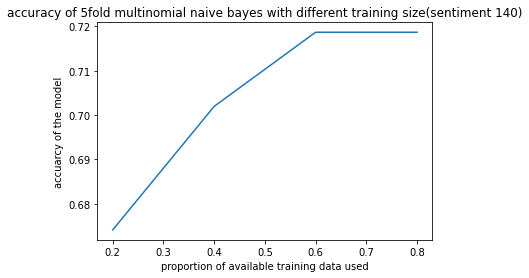

In [22]:
def training_with_different_proportions(x_train, y_train, x_test, y_test, model, ratio):
  length = len(y_train)
  end_idx = int(length * ratio)
  x_train = x_train[:end_idx]
  y_train = y_train[:end_idx]
  model.fit(x_train,y_train)
  test_return = model.predict(x_test)
  return evaluate_acc(y_test, test_return)

x_tr = process_NB_data(X_train_tf, y_train)
x_te = process_NB_data(X_test_tf, y_test)

acc_list = []
acc_list_1 = []
for ratio in range(2, 10, 2):
  ratio = ratio / 10
  acc_list_1.append(training_with_different_proportions(x_tr, y_train, x_te, y_test, MultiNomialNaiveBayes(alpha = 0.98), ratio))
  
xAxis = [0.2, 0.4, 0.6, 0.8]


plt.plot(xAxis,acc_list_1)
plt.title('accuracy of 5fold multinomial naive bayes with different training size(sentiment 140)')
plt.xlabel('proportion of available training data used')
plt.ylabel('accuarcy of the model')

Text(0, 0.5, 'accuarcy of the model')

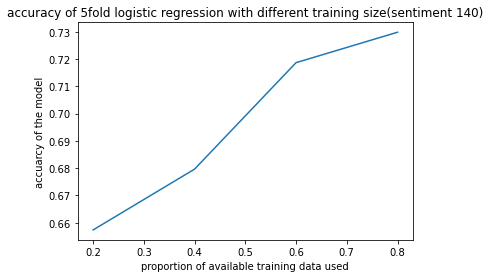

In [23]:
acc_list = []
for ratio in range(2, 10, 2):
  ratio = ratio / 10
  acc_list.append(training_with_different_proportions(X_train_tf, y_train, X_test_tf, y_test, LogisticRegression(max_iter=17032, multi_class='multinomial', solver='saga'), ratio))
  
xAxis = [0.2, 0.4, 0.6, 0.8]
plt.plot(xAxis,acc_list)
plt.title('accuracy of 5fold logistic regression with different training size(sentiment 140)')
plt.xlabel('proportion of available training data used')
plt.ylabel('accuarcy of the model')